In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, r2_score
)

In [4]:
# step 2: load the cleaned dataset
data = pd.read_csv('../data/processed/aggregated_dataset.csv')
print("Cleaned dataset shape:", data.shape)
data.head()

Cleaned dataset shape: (40798, 1029)


,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015,CIR_MEAN,CIR_MAX,CIR_MIN
0,0.0,3.90,745.0,18712.0,10250.0,11576.0,64.0,11855.0,967.0,611.0,...,158.0,198.0,87.0,296.0,505.0,307.0,0.0,395.225394,23077.0,0.0
1,0.0,0.66,749.0,11239.0,6313.0,4712.0,64.0,18968.0,1133.0,447.0,...,228.0,187.0,213.0,202.0,89.0,103.0,0.0,444.060039,18059.0,0.0
2,1.0,7.86,746.0,4355.0,5240.0,3478.0,60.0,14699.0,894.0,723.0,...,174.0,124.0,329.0,207.0,96.0,218.0,0.0,503.485236,16809.0,0.0
3,1.0,3.48,750.0,8502.0,8416.0,5890.0,76.0,8748.0,1127.0,1024.0,...,160.0,434.0,397.0,290.0,155.0,342.0,256.0,413.054134,15742.0,13.0
4,0.0,1.19,746.0,17845.0,18095.0,12058.0,68.0,11380.0,1744.0,276.0,...,296.0,87.0,178.0,314.0,247.0,292.0,256.0,363.357283,19583.0,1.0


In [5]:
# step 3: split data into features and labels
# features (exclude NLOS and RANGE)
X = data.drop(columns=['NLOS', 'RANGE'])

y_class = data['NLOS']  # label (0 = LOS, 1 = NLOS)
y_reg = data['RANGE']

In [6]:
# step 4: split data into training and testing Sets
# split for classification (stratified split)
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class,
    test_size=0.3,
    stratify=y_class,
    random_state=42
)

# split for regression (same indices using random_state=42)
_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_reg,
    test_size=0.3,
    random_state=42
)

# verify shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (28558, 1027)
Testing set shape: (12240, 1027)


In [7]:
# step 5: train random forest models
# initialize models
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# train models
rf_classifier.fit(X_train, y_class_train)
rf_regressor.fit(X_train, y_reg_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

Classification Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      6216
         1.0       0.91      0.80      0.85      6024

    accuracy                           0.86     12240
   macro avg       0.87      0.86      0.86     12240
weighted avg       0.87      0.86      0.86     12240



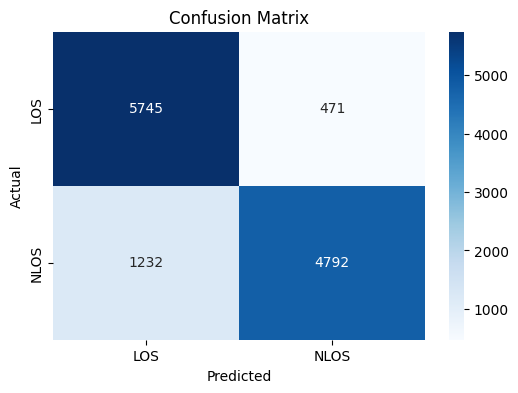

In [8]:
# step 6: evaluate models
# predict on test set
y_class_pred = rf_classifier.predict(X_test)

# calculate metrics
accuracy = accuracy_score(y_class_test, y_class_pred)
report = classification_report(y_class_test, y_class_pred)
cm = confusion_matrix(y_class_test, y_class_pred)

print(f"Classification Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)

# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['LOS', 'NLOS'], yticklabels=['LOS', 'NLOS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

RMSE: 2.37
R² Score: -0.01


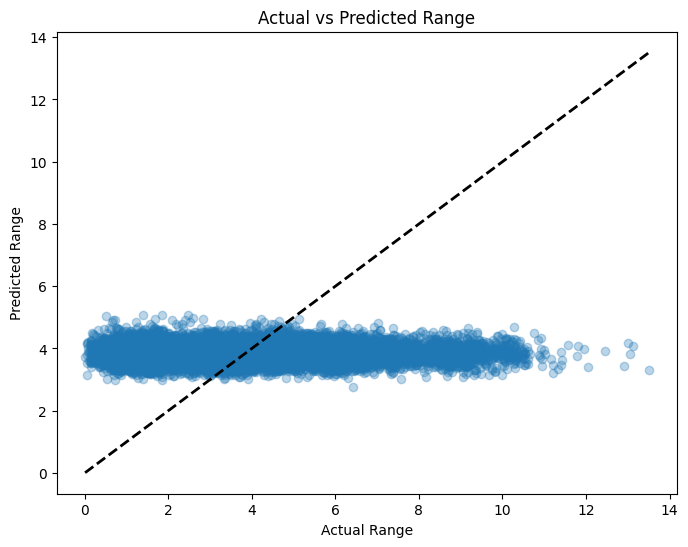

In [9]:
# regression metrics
# predict on test set
y_reg_pred = rf_regressor.predict(X_test)

# calculate metrics
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.3)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'k--', lw=2)
plt.xlabel('Actual Range')
plt.ylabel('Predicted Range')
plt.title('Actual vs Predicted Range')
plt.show()

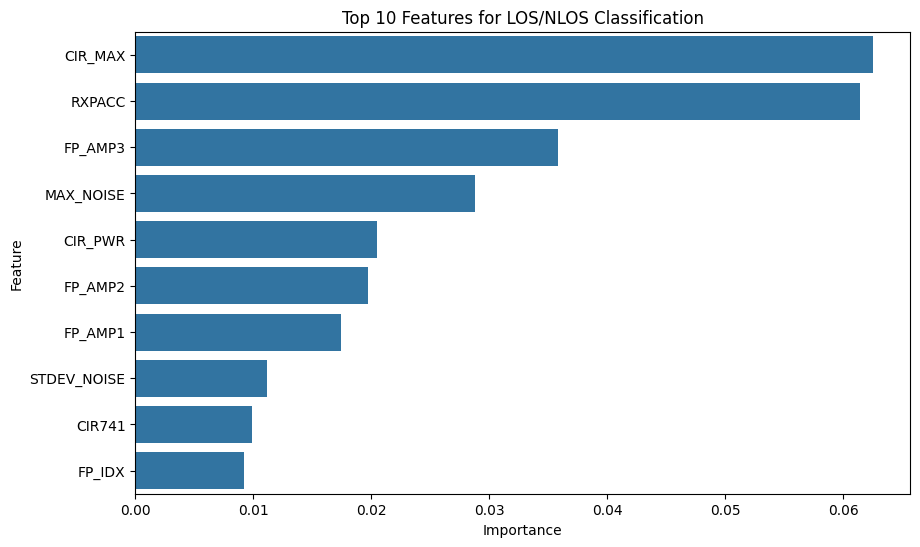

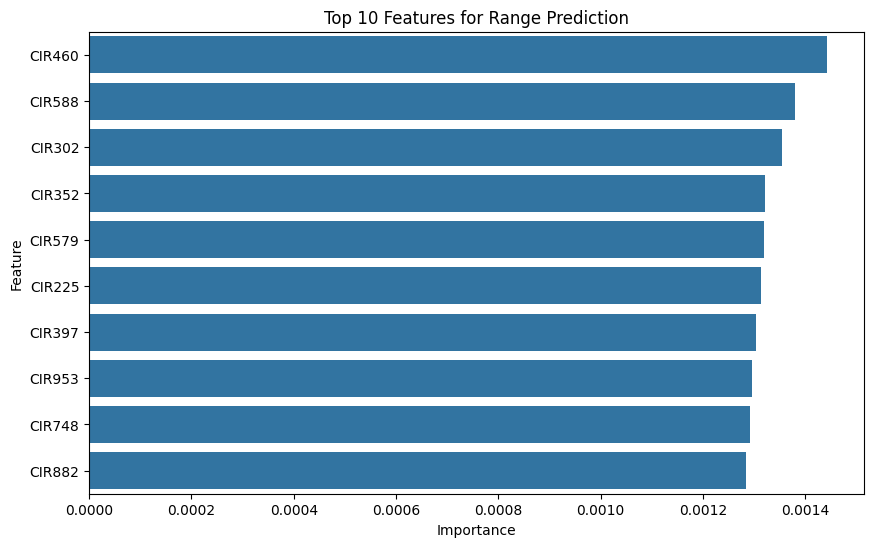

In [10]:
# step 7: feature importance analysis
# get feature importances
feature_importances_class = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importances_reg = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_regressor.feature_importances_
}).sort_values('Importance', ascending=False)

# plot classification feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_class.head(10))
plt.title('Top 10 Features for LOS/NLOS Classification')
plt.show()

# plot regression feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_reg.head(10))
plt.title('Top 10 Features for Range Prediction')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_class_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86
